In [3]:
import numpy as np
import scipy.stats
import sklearn.decomposition
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none' # export SVG text as text, not paths
plt.rcParams['axes.facecolor'] = 'w' # white axes background
plt.rcParams['savefig.facecolor'] = 'w' # white main background, for blog posts

In [4]:
df = pd.read_csv('civdata.csv', index_col=0)
df.head()

,Ahmad al-Mansur,Alexander,Ashurbanipal,Askia,Attila,Augustus Caesar,Bismarck,Boudicca,Casimir III,Catherine,...,Pocatello,Ramesses II,Ram­khamhaeng,Sejong,Shaka,Suleiman,Theodora,Washington,William,Wu Zetian
Boldness,4,8,6,7,8,6,4,6,6,3,...,5,5,5,4,8,8,4,7,4,7
Chattiness,6,7,3,5,5,4,5,5,5,7,...,5,4,6,4,5,6,8,5,4,6
Denounce Willingness,5,7,6,5,6,7,8,6,4,6,...,5,4,5,4,8,7,5,4,5,7
Diplomatic Balance,5,3,5,6,4,7,8,4,6,6,...,5,5,7,6,4,6,6,6,6,6
Friendship Willingness,6,4,5,6,3,5,6,4,6,6,...,5,6,6,7,4,5,7,6,7,4


### Transpose the table to get instances as rows, features as columns

In [5]:
df = df.T
print(df.shape)
df.head()

(43, 63)


,Boldness,Chattiness,Denounce Willingness,Diplomatic Balance,Friendship Willingness,Forgiveness,Loyalty,Meanness,City-State Competitiveness,Neediness,...,Friendly,Guarded,Hostile,Neutrality,War,CS Bully,CS Conquest,CS Friendly,CS Ignore,CS Protect
Ahmad al-Mansur,4,6,5,5,6,5,6,5,5,6,...,8,6,4,5,5,4,4,6,4,6
Alexander,8,7,7,3,4,5,4,7,3,4,...,5,5,7,4,6,3,4,5,4,8
Ashurbanipal,6,3,6,5,5,4,5,5,3,4,...,5,5,6,5,8,5,7,4,4,3
Askia,7,5,5,6,6,4,6,6,4,4,...,6,6,6,5,7,7,8,5,5,4
Attila,8,5,6,4,3,4,4,8,3,3,...,3,3,8,5,8,8,7,4,5,3


# Part 1 - Heatmaps, Normalization, PCA

### 1. Heatmap/Clustermap: Examine raw distribution of values

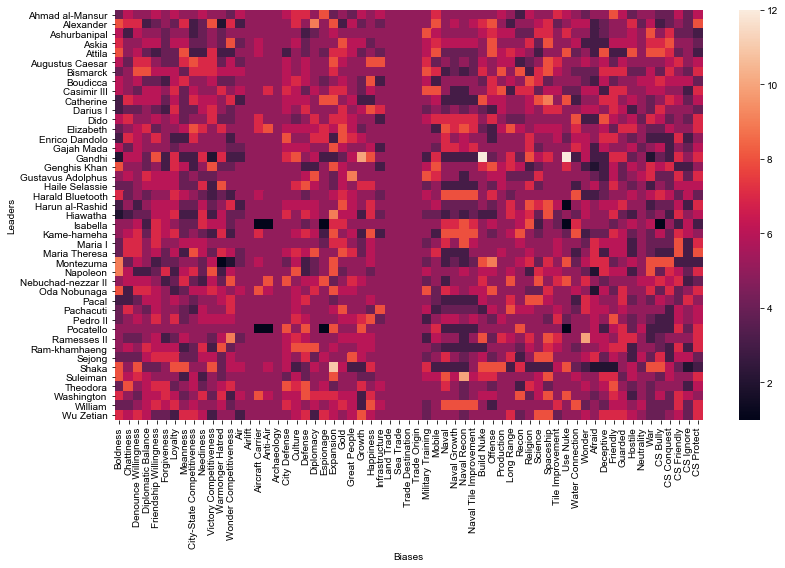

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.heatmap(df, ax=ax, xticklabels=True, yticklabels=True)
ax.set_xlabel('Biases')
ax.set_ylabel('Leaders')
plt.tight_layout()
plt.savefig('figures/heatmap.png', format='png', dpi=90)

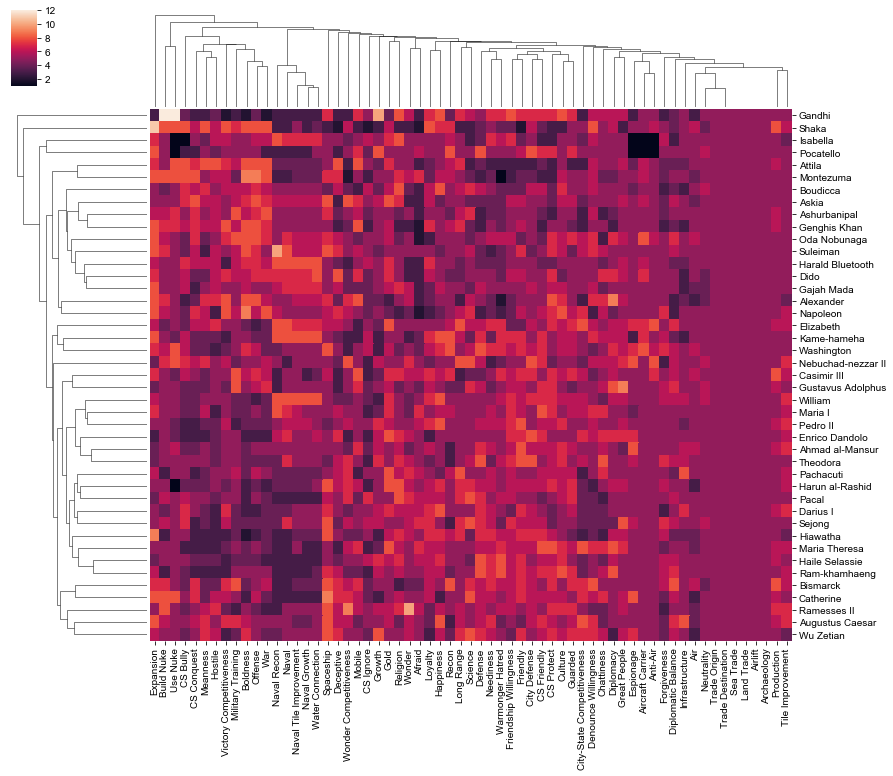

In [7]:
hm = sns.clustermap(df, figsize=(14,12))
hm.fig.subplots_adjust(bottom=0.15) # don't cutoff labels when exporting
plt.savefig('figures/clustermap.png', format='png', dpi=90)

### 2. Shapiro-Wilk Test: Assess normality for possible standardization approaches

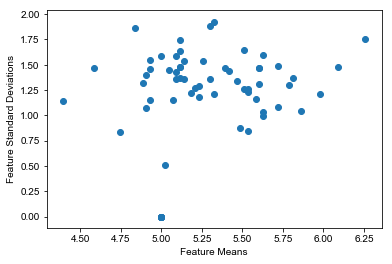

In [8]:
means = df.values.mean(axis=0)
stdevs = df.values.std(axis=0)
plt.scatter(means,stdevs)
plt.xlabel('Feature Means')
plt.ylabel('Feature Standard Deviations')
plt.savefig('figures/feature_means_stdevs.png', format='png', dpi=90)

In [9]:
df_nonzero_var = df.iloc[:,stdevs > 0.0] # drop 0 variance features
df_nonzero_var.shape

(43, 57)

In [10]:
# Shapiro-Wilk test for normality
df_shapiro = pd.DataFrame(index=df_nonzero_var.columns, columns=['p_shapiro', 'log10(p)'])
for i in range(df_nonzero_var.shape[1]):
    feature_name = df_nonzero_var.columns[i]
    feature_values = df_nonzero_var.values[:,i]
    W, pval = scipy.stats.shapiro(feature_values)
    df_shapiro.loc[feature_name,'p_shapiro'] = pval
    df_shapiro.loc[feature_name,'log10(p)'] = np.log10(pval)
df_shapiro.sort_values('p_shapiro', ascending=False, inplace=True)

In [11]:
df_shapiro

,p_shapiro,log10(p)
Wonder Competitiveness,0.0845065,-1.07311
Warmonger Hatred,0.0573639,-1.24136
Expansion,0.03413,-1.46686
Victory Competitiveness,0.0334163,-1.47604
Denounce Willingness,0.0271032,-1.56698
Boldness,0.0261804,-1.58202
Deceptive,0.0252766,-1.59728
Diplomatic Balance,0.0210046,-1.67769
CS Bully,0.0196561,-1.7065
Chattiness,0.0171902,-1.76472


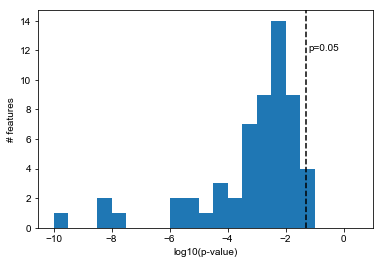

In [12]:
log_pvals = df_shapiro.loc[:,'log10(p)'].values.astype(float)
plt.hist(log_pvals, bins=np.arange(-10,1,0.5))
plt.axvline(x=np.log10(0.05), c='k', ls='--')
plt.xlabel('log10(p-value)')
plt.ylabel('# features')
plt.text(np.log10(0.05)+0.1, 12, 'p=0.05')
plt.savefig('figures/shapiro-wilk_pvalues.png', format='png', dpi=90)

### 3. PCA biplot to visualize broader trends in the data in 2D

In [15]:
''' Center values such that each feature has mean 0
    Not scaling for variance since all values already bounded 1-12 '''
X = df.values
means = X.mean(axis=0)
X_cent = X - means[np.newaxis,:]
df_cent = pd.DataFrame(index=df.index, columns=df.columns, data=X_cent)

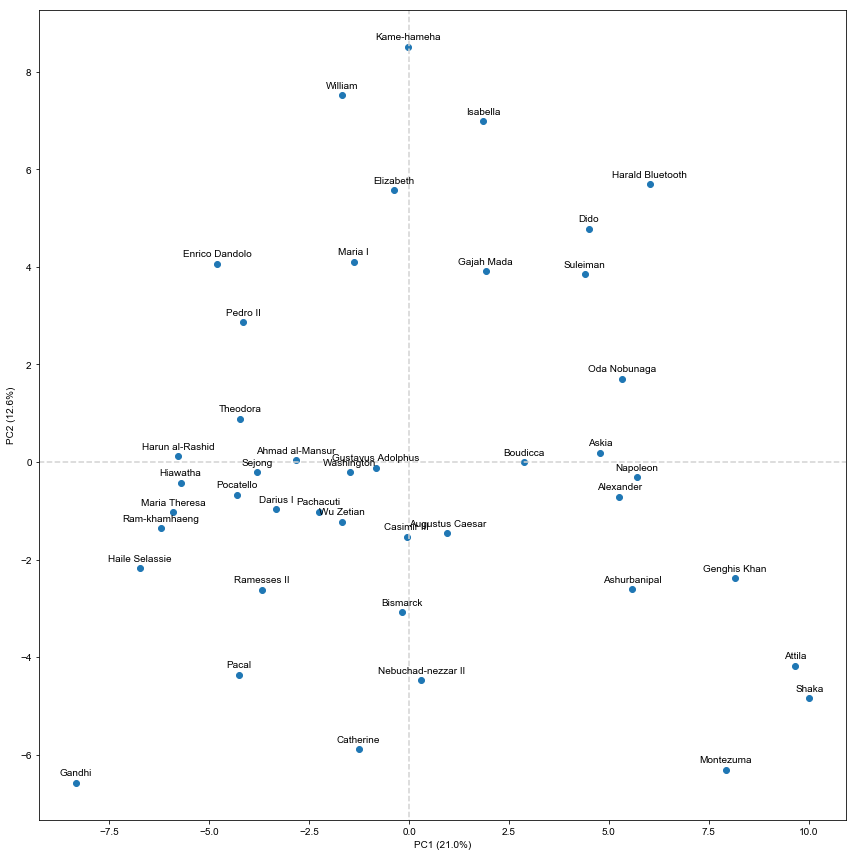

In [62]:
pca = sklearn.decomposition.PCA(n_components=np.min(X_cent.shape))
pca.fit(X_cent)
top2pcs = pca.transform(X_cent)[:,:2] # coordinates of leaders in top 2 PC space
top2var = pca.explained_variance_ratio_[:2] # variance explained by top 2 PCs

fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.scatter(top2pcs[:,0], top2pcs[:,1])
ax.set_xlabel('PC1 (' + str(round(100*top2var[0],1)) + '%)')
ax.set_ylabel('PC2 (' + str(round(100*top2var[1],1)) + '%)')
ax.axvline(x=0, ymin=np.min(top2pcs[:,1]), ymax=np.max(top2pcs[:,1]), color='lightgray', ls='--')
ax.axhline(y=0, xmin=np.min(top2pcs[:,0]), xmax=np.max(top2pcs[:,0]), color='lightgray', ls='--')
for i,leader in enumerate(df_cent.index):
    x = top2pcs[i,0]
    y = top2pcs[i,1]
    ax.text(x,y+0.15,leader,ha='center')
plt.tight_layout()
plt.savefig('figures/pca_biplot.png', format='png', dpi=90)

In [33]:
''' Examine PCA loadings (which features contribute most to top PCs) '''
pc_labels = map(lambda x: 'PC' + str(x), range(1, df_cent.shape[0]+1))
df_pca = pd.DataFrame(index=pc_labels, columns=df_cent.columns, data=pca.components_)
df_pca.head()

,Boldness,Chattiness,Denounce Willingness,Diplomatic Balance,Friendship Willingness,Forgiveness,Loyalty,Meanness,City-State Competitiveness,Neediness,...,Friendly,Guarded,Hostile,Neutrality,War,CS Bully,CS Conquest,CS Friendly,CS Ignore,CS Protect
PC1,0.338237,-0.034336,0.079327,-0.066414,-0.151995,-0.046239,-0.047595,0.169865,-0.020108,-0.142480,...,-0.178009,-0.094547,0.172610,-0.029772,0.300072,0.147413,0.233054,-0.179313,-0.026860,-0.136220
PC2,-0.021680,0.030155,0.013339,-0.025520,0.096447,0.124960,0.006528,-0.067575,0.094320,-0.004403,...,0.044073,-0.008994,-0.007844,0.003402,-0.062493,-0.139716,-0.117527,0.039469,0.066325,0.057463
PC3,-0.053403,-0.139639,-0.035297,-0.178848,0.035002,0.024050,0.282270,-0.070266,-0.258637,0.074013,...,-0.068147,-0.053258,-0.086405,-0.003800,0.022796,0.092814,-0.142999,-0.053250,0.052015,-0.185180
PC4,0.088697,0.130594,0.105114,0.111168,0.005821,0.150318,-0.042628,-0.082509,0.247609,0.093696,...,0.053326,0.096223,-0.086436,-0.050903,0.073282,-0.278208,-0.026540,0.087386,-0.186782,0.306913
PC5,0.042152,0.021796,-0.075882,-0.172043,-0.039647,-0.054722,-0.228488,0.049279,-0.129260,-0.088447,...,-0.065399,-0.010937,0.139511,0.017358,-0.013613,-0.242910,-0.008529,-0.140678,0.022983,-0.003329


In [44]:
''' Look at the features contributing most to the top 2 PCs'''
print('Principal Component 1')
df_pc1 = df_pca.loc['PC1',:]
df_pc1_abs = df_pc1.map(np.abs)
df_pc1_top10 = df_pc1_abs.sort_values(ascending=False).head(10)
df_pc1_top10 = df_pc1.loc[df_pc1_top10.index]
print(df_pc1_top10,'\n')

print('Principal Component 2')
df_pc2 = df_pca.loc['PC2',:]
df_pc2_abs = df_pc2.map(np.abs)
df_pc2_top10 = df_pc2_abs.sort_values(ascending=False).head(10)
df_pc2_top10 = df_pc2.loc[df_pc2_top10.index]
print(df_pc2_top10)

Principal Component 1
Boldness                   0.338237
War                        0.300072
Offense                    0.286370
CS Conquest                0.233054
Defense                   -0.226085
Warmonger Hatred          -0.216079
Expansion                  0.215704
Victory Competitiveness    0.202191
Afraid                    -0.190091
CS Friendly               -0.179313
Name: PC1, dtype: float64 

Principal Component 2
Naval Recon               0.412875
Naval                     0.407360
Naval Growth              0.324036
Water Connection          0.316413
Naval Tile Improvement    0.305627
Use Nuke                 -0.297522
Build Nuke               -0.214658
CS Bully                 -0.139716
Wonder                   -0.129353
Forgiveness               0.124960
Name: PC2, dtype: float64


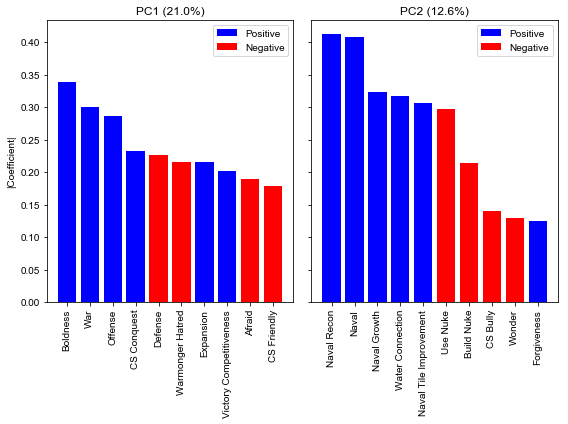

In [66]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,2, figsize=(8,6), sharey=True)
legend_elements = [Patch(facecolor='blue', label='Positive'),
                   Patch(facecolor='red', label='Negative')]

colors1 = list(map(lambda x: 'red' if x < 0 else 'blue', df_pc1_top10))
axs[0].bar(range(10), np.abs(df_pc1_top10.values), color=colors1)
axs[0].set_xticks(range(10))
axs[0].set_xticklabels(df_pc1_top10.index, rotation=90)
axs[0].set_title('PC1 (' + str(round(100*top2var[0],1)) + '%)')
axs[0].set_ylabel('|Coefficient|')
axs[0].legend(handles=legend_elements)

colors2 = list(map(lambda x: 'red' if x < 0 else 'blue', df_pc2_top10))
axs[1].bar(range(10), np.abs(df_pc2_top10.values), color=colors2)
axs[1].set_xticks(range(10))
axs[1].set_xticklabels(df_pc2_top10.index, rotation=90)
axs[1].set_title('PC2 (' + str(round(100*top2var[1],1)) + '%)')
axs[1].legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('figures/pca_biplot_features.png', format='png', dpi=90)